In [26]:
from sklearn.model_selection import train_test_split

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import pandas as pd
import numpy as np

def getData(filename):
  canData=[] #List to store CAN data
  f = open(filename)
  #read_file = reader(f)
  read_file =f.readlines()
  
  #file = list(read_file)
  speed = []
  rpm = []
  i = 0
  for row in read_file:
    #Change the positions of the values if needed
    record = {'stamp':row[1:18], 'PID':row[25:28], 'const1':row[29:33], 
'change':row[33:41],'value':int(row[41:45], 16), 'value2':0 ,'attack':0}
    
    if record["PID"] == '254': #Processing of speed
      if record["value"] >= 4095:
        record["attack"] = 1
      record['value'] =  (record['value'] * 0.62137119) /100
      speed.append(record['value'])
    
    if record["PID"] == '115': #Processing of RPM 
      if record["value"] >= 65535:
        record["attack"] = 1
      record['value'] =  (record['value'] * 2)
      rpm.append(record['value'])

    i = i+1   
    canData.append(record)
    record={}
    
  f.close()
  return canData

def dict_to_df(dict):

  #load dictionary to dataframe
  df = pd.DataFrame.from_dict(dict)
  df = df.drop(columns=['stamp','const1','change','value2'])
  df = df.loc[(df['PID'] == '115') | (df['PID'] == '254')]
  df = df.reset_index(drop=True)
  one_hot = pd.get_dummies(df['PID'])
  df = df.drop('PID',axis = 1)
  df = df.join(one_hot)
  df = df[['115', '254', 'value', 'attack']]
  df.rename(columns = {'115':'RPM', '254':'Speed'}, inplace = True)
  df.loc[df['RPM'] == 1, 'RPM'] = df['value']
  df.loc[df['Speed'] == 1, 'Speed'] = df['value']
  df = df.drop(columns=['value'])

  return df

#edit file name with file directory of downloaded log files
fff_injection_df = dict_to_df(getData("CAN Bus log - injection of FFF as the speed reading.log"))
rpm_injection_df = dict_to_df(getData("CAN Bus log - injection of RPM readings.log"))
no_injection_df = dict_to_df(getData("CAN bus log - no injection of messages.log"))

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5012\1272064848.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[626. 624. 624. ... 900. 906. 906.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df['RPM'] == 1, 'RPM'] = df['value']
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5012\1272064848.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.          0.          0.         ... 25.44515023 25.44515023
 25.44515023]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df['Speed'] == 1, 'Speed'] = df['value']
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5012\1272064848.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[   740.    742.    744. ..

In [7]:
print(fff_injection_df.head())

     RPM  Speed  attack
0  626.0  False       0
1  False    0.0       0
2  624.0  False       0
3  False    0.0       0
4  624.0  False       0


In [13]:
print(no_injection_df.shape)
print(fff_injection_df.shape)
print(rpm_injection_df.shape)

(1649, 3)
(14435, 3)
(4543, 3)


In [20]:
combined_df = pd.concat([fff_injection_df, rpm_injection_df, no_injection_df], ignore_index=True)

# Replace false with NaN
combined_df.replace(False, np.nan, inplace=True)

# fill NaN values with 0 
combined_df.fillna(0, inplace=True)

# Save as a CSV file
combined_df.to_csv('combined_CAN_log.csv', index=False)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_5012\334814044.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df.replace(False, np.nan, inplace=True)


In [21]:
print(combined_df.shape)

(20627, 3)


In [33]:
df = pd.read_csv('combined_CAN_log.csv')
print(df.head())
print(df.shape)

     RPM  Speed  attack
0  626.0    0.0       0
1    0.0    0.0       0
2  624.0    0.0       0
3    0.0    0.0       0
4  624.0    0.0       0
(20627, 3)


In [29]:
attack_counts = df['attack'].value_counts()
print(attack_counts)

attack
1    11790
0     8837
Name: count, dtype: int64


In [27]:
X = df[['RPM', 'Speed']]  
y = df['attack']  

# Splitting the dataset 3/4 for training and 1/4 for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2212
           1       1.00      1.00      1.00      2945

    accuracy                           1.00      5157
   macro avg       1.00      1.00      1.00      5157
weighted avg       1.00      1.00      1.00      5157



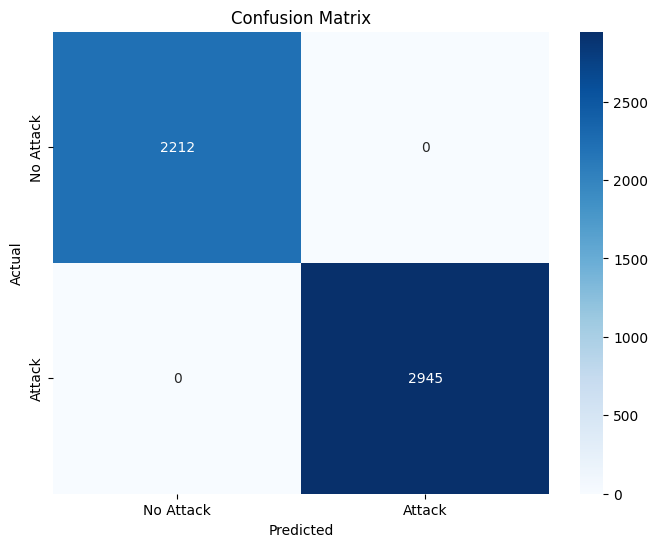

In [32]:
# Initializing Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Training the model 
rf_model.fit(X_train, y_train)

# Make predictions on test data
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

# plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Attack', 'Attack'], yticklabels=['No Attack', 'Attack'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()